In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_absolute_error


%matplotlib inline

In [ ]:
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [ ]:
X = iris.data[:, 2:] # petal length and width
target_names = iris.target_names
feature_names = iris.feature_names[2:]

y = iris.target

Деревья

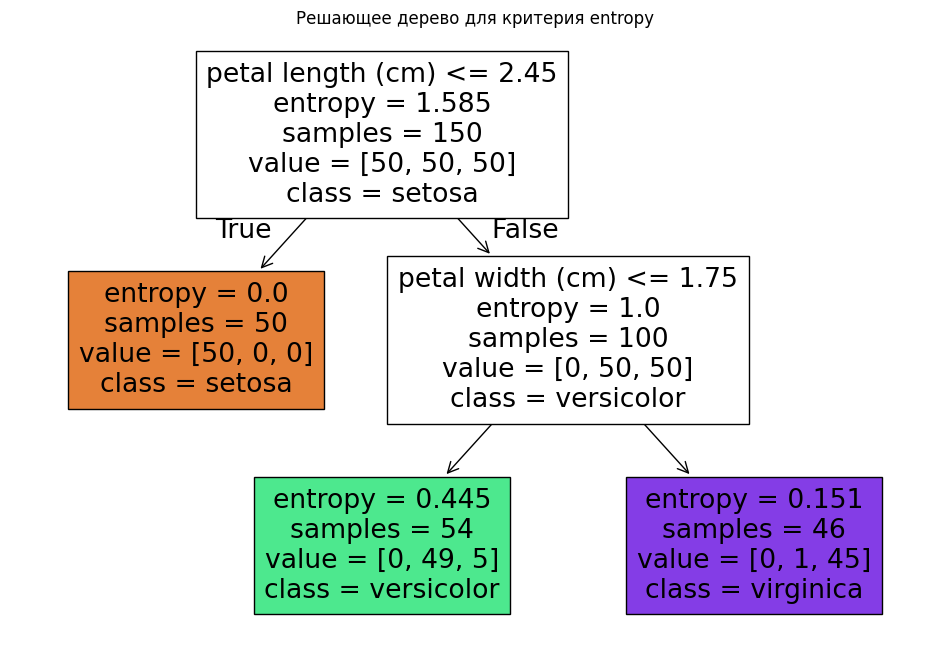

In [ ]:
# Задание: постройте и визуализируйте структуру решающего дерева
# для критерия разбиения “entropy"

tree_clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree_clf_entropy.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(tree_clf_entropy, feature_names=iris.feature_names[2:], class_names=iris.target_names, filled=True)
plt.title("Решающее дерево для критерия entropy")
plt.show()

1.6

In [ ]:
train = pd.read_csv('train_features.csv').fillna(0)
y = pd.read_csv('train_target.csv', index_col='id')

In [ ]:
train.drop('Year', axis=1, inplace=True)
types = train.dtypes
real_cols = list(types[types != 'object'].index.values)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
dt = DecisionTreeRegressor()
dt.fit(x_train[real_cols], y_train)

DecisionTreeRegressor()

In [ ]:
mse_train = []
mse_val = []
for i in range(20):
    dt = DecisionTreeRegressor(max_depth=i*5+1, min_samples_leaf=1000)
    dt.fit(x_train[real_cols], y_train)
    mse_train = np.append(mse_train, mean_absolute_error(dt.predict(x_train[real_cols]), y_train))
    mse_val = np.append(mse_val, mean_absolute_error(dt.predict(x_val[real_cols]), y_val))

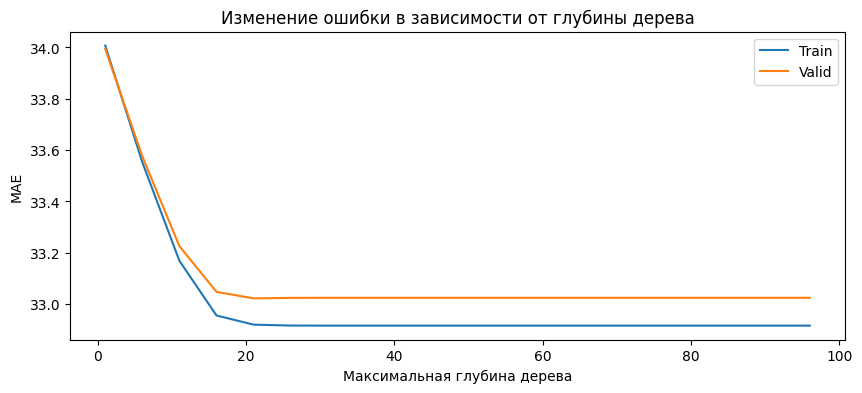

In [ ]:
plt.figure(figsize=(10, 4))
plt.title('Изменение ошибки в зависимости от глубины дерева')
plt.plot([i*5 + 1 for i in range(20)], mse_train, label='Train')
plt.plot([i*5 + 1 for i in range(20)], mse_val, label='Valid')
plt.legend()
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('MAE')
plt.show()

# обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе.
# визуализируйте MAE

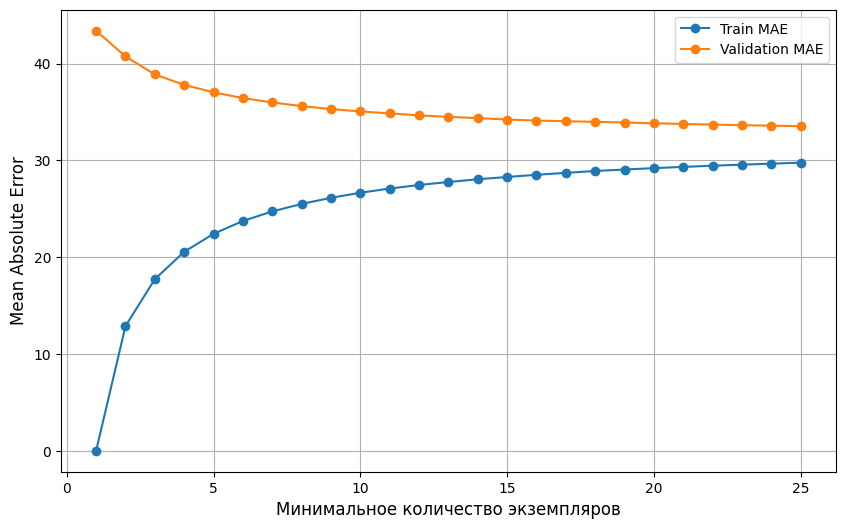

In [ ]:
mse_train = []
mse_val = []

min_samples_leaf_values = range(1, 26)

for min_samples_leaf in min_samples_leaf_values:
    dt = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
    dt.fit(x_train[real_cols], y_train)
    mse_train.append(mean_absolute_error(dt.predict(x_train[real_cols]), y_train))
    mse_val.append(mean_absolute_error(dt.predict(x_val[real_cols]), y_val))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, mse_train, label='Train MAE', marker='o')
plt.plot(min_samples_leaf_values, mse_val, label='Validation MAE', marker='o')
plt.xlabel('Минимальное количество экземпляров', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_dt = DecisionTreeRegressor(min_samples_leaf=25, random_state=42)
best_dt.fit(x_train[real_cols], y_train)

train_mae = mean_absolute_error(best_dt.predict(x_train[real_cols]), y_train)
val_mae = mean_absolute_error(best_dt.predict(x_val[real_cols]), y_val)

print(f"Train MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")

Train MAE: 29.76461419851874
Validation MAE: 33.53678625535291


Ансамбли

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
bag_of_trees = BaggingRegressor(best_dt, n_estimators=5, random_state=42)
bag_of_trees.fit(x_train[real_cols], y_train)
bag_mse_val = mean_absolute_error(bag_of_trees.predict(x_val[real_cols]), y_val)
bag_mse_train = mean_absolute_error(bag_of_trees.predict(x_train[real_cols]), y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


KeyboardInterrupt: 

# Задача: выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor
# Выбрать оптимальные параметры для каждого дерева.

In [ ]:
from sklearn.model_selection import GridSearchCV

y_train_flat = y_train.values.ravel()

x_train = x_train.apply(pd.to_numeric, errors='coerce')
y_train_flat = pd.to_numeric(y_train_flat, errors='coerce')

param_grid = {
    'n_estimators': [2, 4, 6, 8],
    'max_samples': [0.4, 0.7, 1.0],
    'max_features': [0.4, 0.7, 1.0]
}

bagging_regressor = BaggingRegressor(estimator=best_dt, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(bagging_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE: {-grid_search.best_score_}')

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 8}
Лучший MAE: 32.418156623906874


# Задача: обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для Random Forest Regressor

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': ['sqrt', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(rf_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)

x_train = pd.DataFrame(np.random.rand(100, 5), columns=[f"feature_{i}" for i in range(5)])
y_train = np.random.rand(100)
real_cols = [f"feature_{i}" for i in range(5)]

grid_search_rf.fit(x_train[real_cols], y_train)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 4, 6, 8],
                         'max_features': ['sqrt', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [4, 6, 8, 10]},
             scoring='neg_mean_absolute_error', verbose=2)

In [11]:
print(f'Лучшие параметры: {grid_search_rf.best_params_}')
print(f'Лучший MAE: {-grid_search_rf.best_score_}')

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Лучший MAE: 0.2426284551054838


2. Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import numpy as np
import pandas as pd
import pickle
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Задача. Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.
# Визуализировать графики зависимости предсказания от параметров модели.

In [ ]:
dataset = load_dataset('json', data_files={'train': 'train.jsonl', 'test': 'validation.jsonl'})

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out()

tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)

X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()
y_train = dataset['train']['label']
y_test = dataset['test']['label']

X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
# Определение моделей для блэндинга и стэкинга
base_models = [
    ("AdaBoost", AdaBoostClassifier(n_estimators=50, random_state=42)),
    ("GradientBoosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42)
)


In [ ]:
# Результаты для базовых моделей
results = {}

for model_name, model in base_models:
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.2f}")


Training AdaBoost...
AdaBoost Accuracy: 0.35
Training GradientBoosting...
GradientBoosting Accuracy: 0.65
Training RandomForest...
RandomForest Accuracy: 0.65


In [ ]:
# Результаты для стэкинга
print("Training Stacking Model...")
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
results["Stacking"] = stacking_accuracy
print(f"Stacking Model Accuracy: {stacking_accuracy:.2f}")

Training Stacking Model...
Stacking Model Accuracy: 0.65


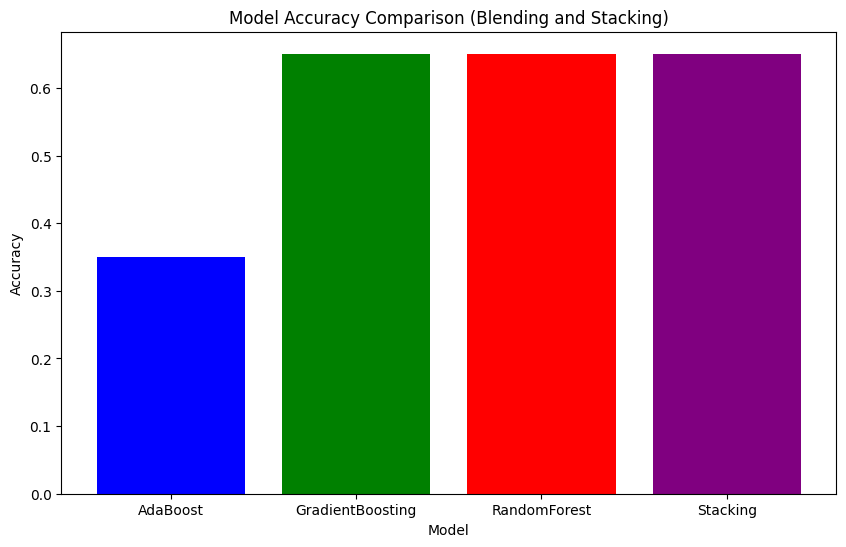

In [ ]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Blending and Stacking)')
plt.show()